## CH13 Exercises: Loading and Preprocessing Data With Tensorflow


- 9. Load the Fashion MNIST dataset:(introduced in Chapter 10);

  - split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files.

  - Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label.

  - Then use tf.data to create an efficient dataset for each set.

  - Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.


1- loading the data


In [113]:
import tensorflow as tf
from tensorflow.keras.datasets.fashion_mnist import load_data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [46]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [47]:
X_train.shape, y_valid.shape, X_test.shape, y_valid[:3]

((55000, 28, 28), (5000,), (10000, 28, 28), array([9, 0, 0], dtype=uint8))

In [48]:
img = X_train[0]
img.shape

(28, 28)

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train),seed=42)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))
test_dataset =  tf.data.Dataset.from_tensor_slices((X_test,y_test))

print('Train Data Length: ', len(train_dataset))
print('Valid Length: ',len(valid_dataset))
print('Test Length: ', len(test_dataset))
train_dataset

Train Data Length:  55000
Valid Length:  5000
Test Length:  10000


<_ShuffleDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

let's save each dataset into multiple tfrecord files, for example 10 files for each data.


In [50]:
next(iter(train_dataset))[0].shape

TensorShape([28, 28])

In [51]:
55000//10 + 55000%10

5500

In [52]:
from tensorflow.train import Example, Features, Feature, BytesList, Int64List

def save_dataset_to_10_tfrecord(data_iter, length, the_type='Train'):
    if the_type == 'Train':
        name = 'train_file'
    elif the_type == 'Valid':
        name = 'valid_file'
    else:
        name = 'test_file'

    for i in range(10):
        with tf.io.TFRecordWriter(f'ignored/{name}{i+1}.tfrecord') as f:
            for _ in range(length // 10):
                try:
                    img, label = next(data_iter)
                    data = tf.io.encode_jpeg(img[..., tf.newaxis])
                    example_with_image = Example(features=Features(feature={
                        "image": Feature(bytes_list=BytesList(value=[data.numpy()])),  # Encoded image data
                        "label": Feature(int64_list=Int64List(value=[label]))  # Label 
                    }))
                    serialized_example = example_with_image.SerializeToString()
                    f.write(serialized_example)
                except StopIteration:
                    print("Data iterator exhausted. Ending early.")
                    break  # Stop if there are no more data

            print(f'{name}{i} file saved successfully')
    
    print('=' * 50)
    print(f'{the_type} files finished.\n','-'*50)


save_dataset_to_10_tfrecord(iter(train_dataset),len(train_dataset), 'Train')
save_dataset_to_10_tfrecord(iter(valid_dataset),len(valid_dataset), 'Valid')
save_dataset_to_10_tfrecord(iter(test_dataset),len(test_dataset), 'Test')

train_file0 file saved successfully
train_file1 file saved successfully
train_file2 file saved successfully
train_file3 file saved successfully
train_file4 file saved successfully
train_file5 file saved successfully
train_file6 file saved successfully
train_file7 file saved successfully
train_file8 file saved successfully
train_file9 file saved successfully
Train files finished.
 --------------------------------------------------
valid_file0 file saved successfully
valid_file1 file saved successfully
valid_file2 file saved successfully
valid_file3 file saved successfully
valid_file4 file saved successfully
valid_file5 file saved successfully
valid_file6 file saved successfully
valid_file7 file saved successfully
valid_file8 file saved successfully
valid_file9 file saved successfully
Valid files finished.
 --------------------------------------------------
test_file0 file saved successfully
test_file1 file saved successfully
test_file2 file saved successfully
test_file3 file saved succe

ok, we saved each dataset into 10 tfrecord files, now we try to read them again..


In [66]:
feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
        }

def parse(serialized_example):
        example = tf.io.parse_single_example(serialized_example,feature_description)
        image = tf.io.decode_jpeg(example["image"].values[0])
        image = tf.reshape(image, shape=[28,28])
        return image, example["label"]

In [72]:
for x,y in (tf.data.TFRecordDataset('ignored\\train_file5.tfrecord')).map(parse).batch(30).take(2):
    print(x.shape, y.shape)
    print(y)

(30, 28, 28) (30,)
tf.Tensor([6 6 2 7 0 7 3 3 2 7 9 6 2 3 3 6 2 9 2 4 3 9 0 1 1 1 6 4 6 1], shape=(30,), dtype=int64)
(30, 28, 28) (30,)
tf.Tensor([0 9 1 4 0 2 3 1 3 8 7 7 6 6 5 3 5 5 5 0 6 0 5 2 3 1 1 3 2 9], shape=(30,), dtype=int64)


In [54]:
train_filepaths = 'ignored/train_file*.tfrecord'
train_filepath_dataset = tf.data.Dataset.list_files(train_filepaths,seed=42)

valid_filepaths = 'ignored/valid_file*.tfrecord'
valid_filepath_dataset =  tf.data.Dataset.list_files(valid_filepaths,shuffle=False)

test_filepaths = 'ignored/test_file*.tfrecord'
test_filepath_dataset =  tf.data.Dataset.list_files(test_filepaths,shuffle=False)



print(train_filepath_dataset, len(train_filepath_dataset))
print(list(train_filepath_dataset.as_numpy_iterator()))

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)> 10
[b'ignored\\train_file5.tfrecord', b'ignored\\train_file9.tfrecord', b'ignored\\train_file6.tfrecord', b'ignored\\train_file4.tfrecord', b'ignored\\train_file7.tfrecord', b'ignored\\train_file10.tfrecord', b'ignored\\train_file2.tfrecord', b'ignored\\train_file8.tfrecord', b'ignored\\train_file3.tfrecord', b'ignored\\train_file1.tfrecord']


### reading the data from files:

In [106]:
def reader(filepath_dataset, n_readers=10):
    return filepath_dataset.interleave(num_parallel_calls=tf.data.AUTOTUNE,
            map_func = lambda filepath: tf.data.TFRecordDataset(filepath).map(parse),
            cycle_length=n_readers).cache().batch(32).prefetch(1)

train_dataset = reader(train_filepath_dataset)
valid_dataset = reader(valid_filepath_dataset)
test_dataset = reader(test_filepath_dataset)

In [107]:
for x, y in train_dataset.take(1):
    print(f"Input: {x.shape}, Label: {y.shape}")


Input: (32, 28, 28), Label: (32,)


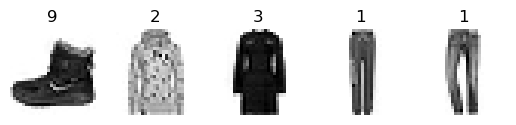

In [93]:
for X, y in valid_dataset.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

### Wrap Up:


### Model


In [108]:
sample_image_batches = train_dataset.take(100).map(lambda image, label: image)

In [115]:
np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                            axis=0).astype(np.float32).shape

(3200, 28, 28)

In [122]:
tf.random.set_seed(42)

norm_layer = tf.keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_dataset.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                            axis=0).astype(np.float32)
norm_layer.adapt(sample_images)

model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='leaky_relu'),
    tf.keras.layers.Dense(128,activation='leaky_relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

In [118]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normaliza  (None, 28, 28)            57        
 tion)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               401920    
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dense_20 (Dense)            (None, 10)                1290      
                                                                 
Total params: 468931 (1.79 MB)
Trainable params: 468874 (1.79 MB)
Non-trainable params: 57 (232.00 Byte)
_______________

In [123]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])


In [124]:
history = model.fit(train_dataset,epochs=5,validation_data=valid_dataset)

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4623 - accuracy: 0.8320 - val_loss: 0.3827 - val_accuracy: 0.8618
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3587 - accuracy: 0.8674 - val_loss: 0.3733 - val_accuracy: 0.8712
Epoch 3/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3192 - accuracy: 0.8808 - val_loss: 0.3770 - val_accuracy: 0.8696
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2942 - accuracy: 0.8904 - val_loss: 0.3776 - val_accuracy: 0.8782
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2755 - accuracy: 0.8967 - val_loss: 0.3970 - val_accuracy: 0.8760


---